# Bubble sheet evaluator
Bubble sheet evaluator is an OCR (mini) project where the ultimate goal is to automate the bubble answer sheet evaluating process.

**objectives:**
   - build a bubble detector
   
   - based on detected bubble and the provided correct answer, evaluate the answer sheet.

In [1]:
# !pip install imutils
# ! pip install matplotlib
# ! pip install pandas
# ! pip install statistics

In [2]:
import cv2 as cv
import numpy as np 
import imutils
import matplotlib.pyplot as plt
import pandas as pd
import statistics

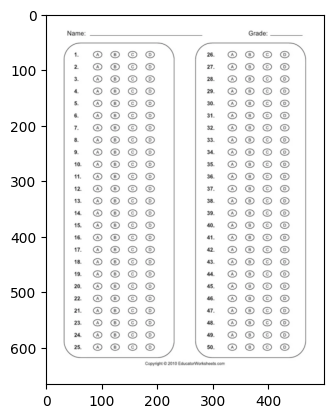

In [3]:
img = cv.imread("../data/answer_sheet2.jpg")
# resize image
img = imutils.resize(img, width=500)
plt.imshow(img)

## Preprocessing

In [4]:
def preprocessing(img):
    # colored image to gray scale image
    gray_image = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # blurring the image
    
    gauss_image = cv.GaussianBlur(gray_image, (5,5,), 0)
    
    # erosion
#     kernel = np.ones((1,1), np.uint8)      
#     close_image = cv.morphologyEx(gauss_image, cv.MORPH_CLOSE, kernel)
    
    kernel = np.ones((3,3), np.uint8)      
    close_image = cv.morphologyEx(gauss_image, cv.MORPH_OPEN, kernel)
    
    #opening -> erosion + dilation
    #closing -> dilation + erosion
    
    #close_image = cv.dilate(close_image, kernel, iterations=1)
    # noise filter
    median_blur= cv.medianBlur(close_image, 1)
    
    # binary image
    # blockSize = 11; Size of a pixel neighborhood that is used to calculate a threshold value for the pixel,
    # constant = 2 subtracted from mean or weighted mean
    binary_image =  cv.adaptiveThreshold(median_blur, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,2 )

    #otsu thresholding
#     ret3,binary_image = cv.threshold(median_blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    return binary_image

In [5]:
def bubble_contour_extractor(contours):
    contours_features = []
    for cnt in contours:
        if len(cnt) > 3:
            area = cv.contourArea(cnt)
            length = len(cnt)
            parimeter =  cv.arcLength(cnt,False)
            contours_features.append([area, length, parimeter]) 
    contours_features = np.array(contours_features)
    return contours_features


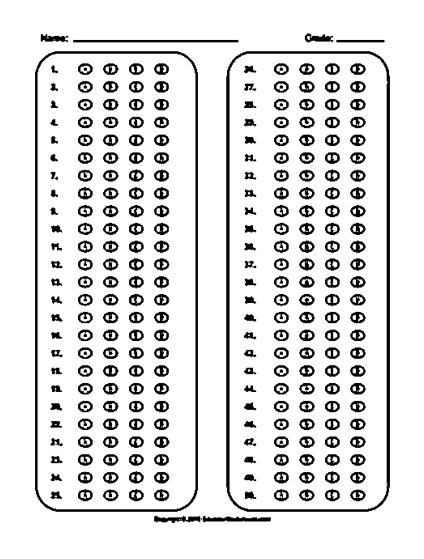

In [6]:
plt.figure(figsize=(10,7))
plt.axis(False)
binary_image = preprocessing(img)
plt.imshow(binary_image, cmap='gray');

In [7]:
# find all the contours in the image
contours = cv.findContours(binary_image, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
ctrs = imutils.grab_contours(contours)
print(type(ctrs))

<class 'tuple'>


In [8]:
contours_features = bubble_contour_extractor(ctrs)

In [9]:
# checking the distribution of contours_features i.e area and length
df = pd.DataFrame(contours_features, columns=["area", "length", "parimeter"])

In [10]:
df.corr()

,area,length,parimeter
area,1.000000,0.276518,0.902757
length,0.276518,1.000000,0.547185
parimeter,0.902757,0.547185,1.000000


## Visualizing multiple (answer sheets) images

In [11]:
def multi_image_plot(image_list, dim = (2,2), figsize=(15, 15), title="", sharey=False, sharex=True, tight_layout=False, cmap='gray'):
    fig, axes = plt.subplots(dim[0], dim[1], figsize=figsize, sharey=sharey, sharex=sharex)
    fig.suptitle(title, fontsize=16)
    
    if tight_layout:
        fig.tight_layout()
    cursor = 0
    for i in range(0,dim[0]):
        for j in range(0,dim[1]):
            if cursor >= len(image_list):
                break
            axes[i][j].imshow(image_list[cursor], cmap=cmap)
            axes[i][j].axis('off')
            axes[i][j].set_title(f"sheet_{cursor+1}")
            
            cursor += 1
            
    plt.show()

In [12]:
image_container = []
for i in range(1,5):
    img_ = cv.imread(f"../data/answer_sheet{i}.jpg")
    # resize image
    img_ = imutils.resize(img_, width=500)
    image_container.append(img_)

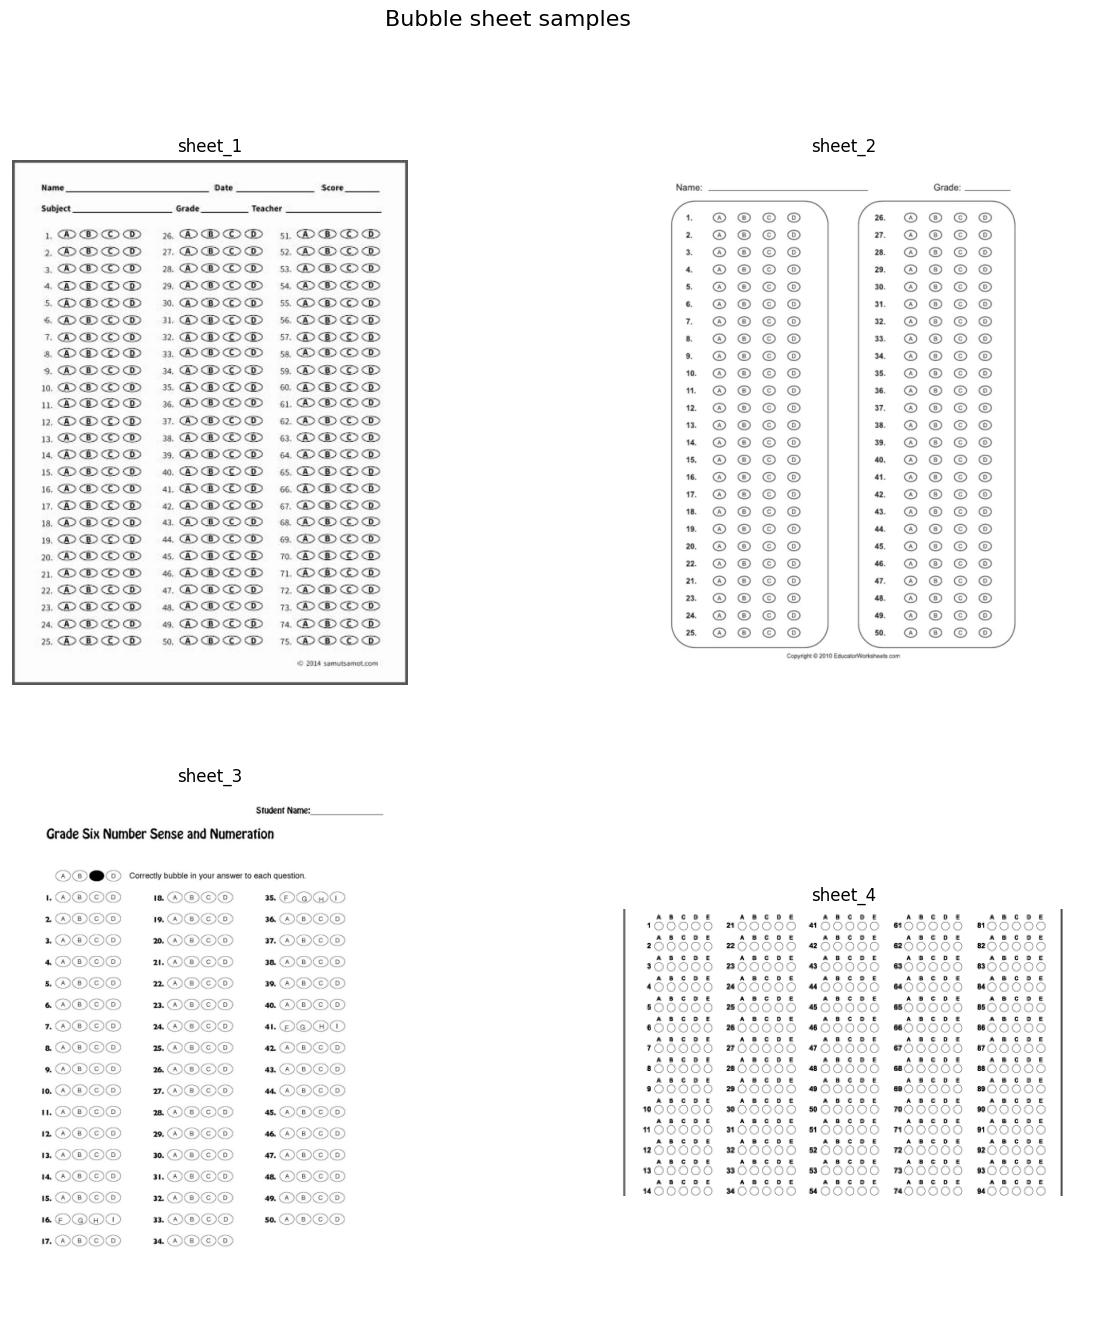

In [13]:
multi_image_plot(image_container, title="Bubble sheet samples")

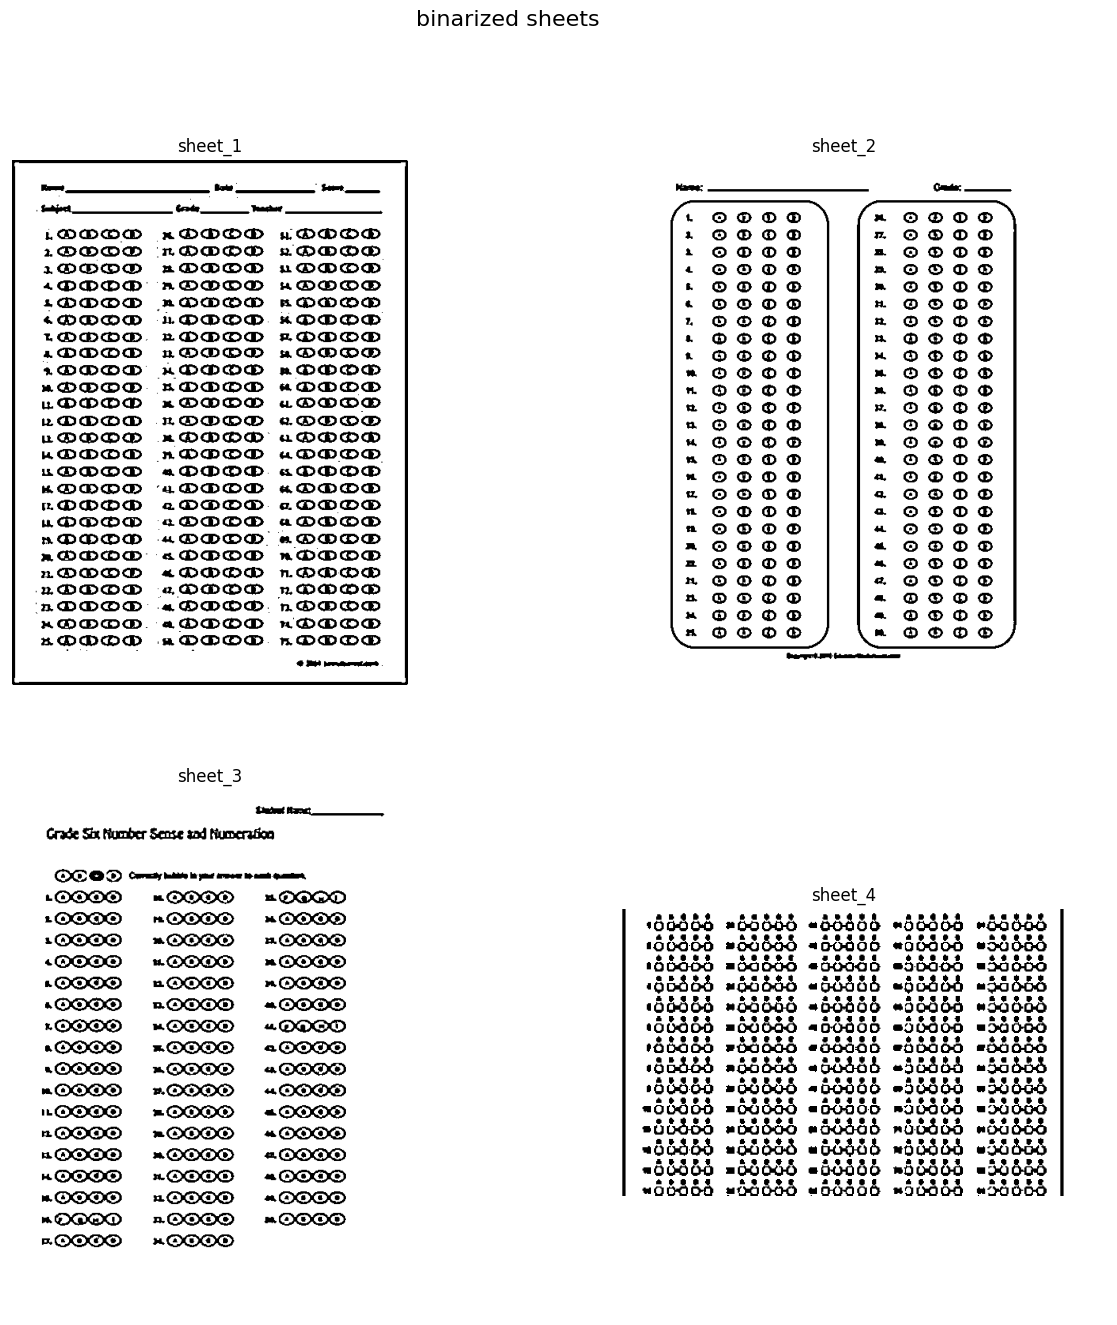

In [14]:
preprocessed_images = [preprocessing(img) for img in image_container]
multi_image_plot(preprocessed_images, title="binarized sheets")

# Approach 1: histogoram

# Phase I: contour detection

In [15]:
def generate_histogram(list_, n_bins=4):
    max_value, min_value = max(list_), min(list_)
    bin_size = (max_value - min_value)/n_bins
    bins_ranges = [(min_value+i*bin_size, min_value+(i+1)*bin_size) for i in range(0, n_bins)]
    histogram = {x:0 for x in range(len(bins_ranges))}
    for i in list_:
        for index, bin_ in enumerate(bins_ranges):
            if i < bin_[1] and  i >= bin_[0]:
                histogram[index] += 1
    return histogram, bins_ranges
    
    

In [16]:
def get_max_bin_thresholds(histogram, bins_ranges):
    hist = dict(sorted(histogram.items(), key=lambda item: item[1], reverse=True))
    return bins_ranges[list(hist.keys())[0]]

In [17]:
# testing generate_histogram()
generate_histogram([1,2,3,4,5,6,7,8,9,10], 3)

({0: 3, 1: 3, 2: 3}, [(1.0, 4.0), (4.0, 7.0), (7.0, 10.0)])

In [18]:
def remove_outlier(df, columns=["area"], upper_bound=0.99, lower_bound=0.01, _type="drop"):
    if _type == "clip":
        for col in columns:
            df[col] = df[col].clip(
                        lower=df[col].quantile(lower_bound),
                        upper=df[col].quantile(upper_bound)
                        )
    elif _type == "drop":
        for col in columns:
            df_temp = df[df[col] < df[col].quantile(upper_bound)]
            df = df_temp[df_temp[col] > df_temp[col].quantile(lower_bound)]  
    else:
        raise Exception("_type takes either 'clip' or 'drop' ")
    return df
    

In [19]:
df.shape

(652, 3)

In [20]:
# df_new = remove_outlier(df.copy(), columns=["area"])
# df = df_new

In [21]:
histogram, bins_ranges = generate_histogram(df["area"], n_bins=3)

In [22]:
lower_bound, upper_bound = get_max_bin_thresholds(histogram, bins_ranges)
lower_bound, upper_bound

(1.0, 110612.33333333333)

## plotting histogram of area

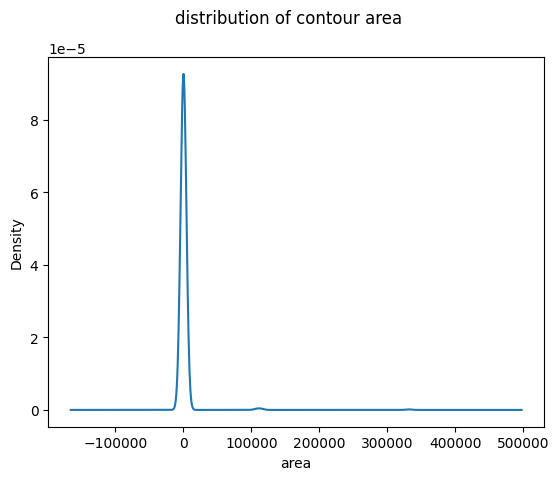

In [23]:
df["area"].plot(kind="kde")
plt.xlabel("area")
plt.suptitle("distribution of contour area")
plt.show();

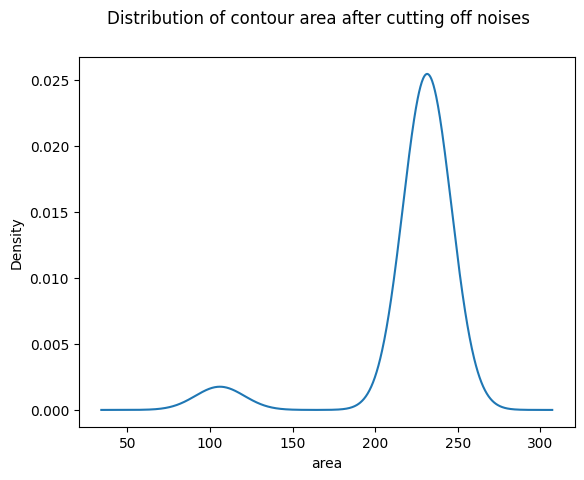

In [24]:
df = df[(df["area"] < 500) & (df["area"] > 100) & (df["length"] > 5) & (df["length"] < 20)]

df["area"].plot(kind="kde")
plt.xlabel("area")
plt.suptitle("Distribution of contour area after cutting off noises")
plt.show();

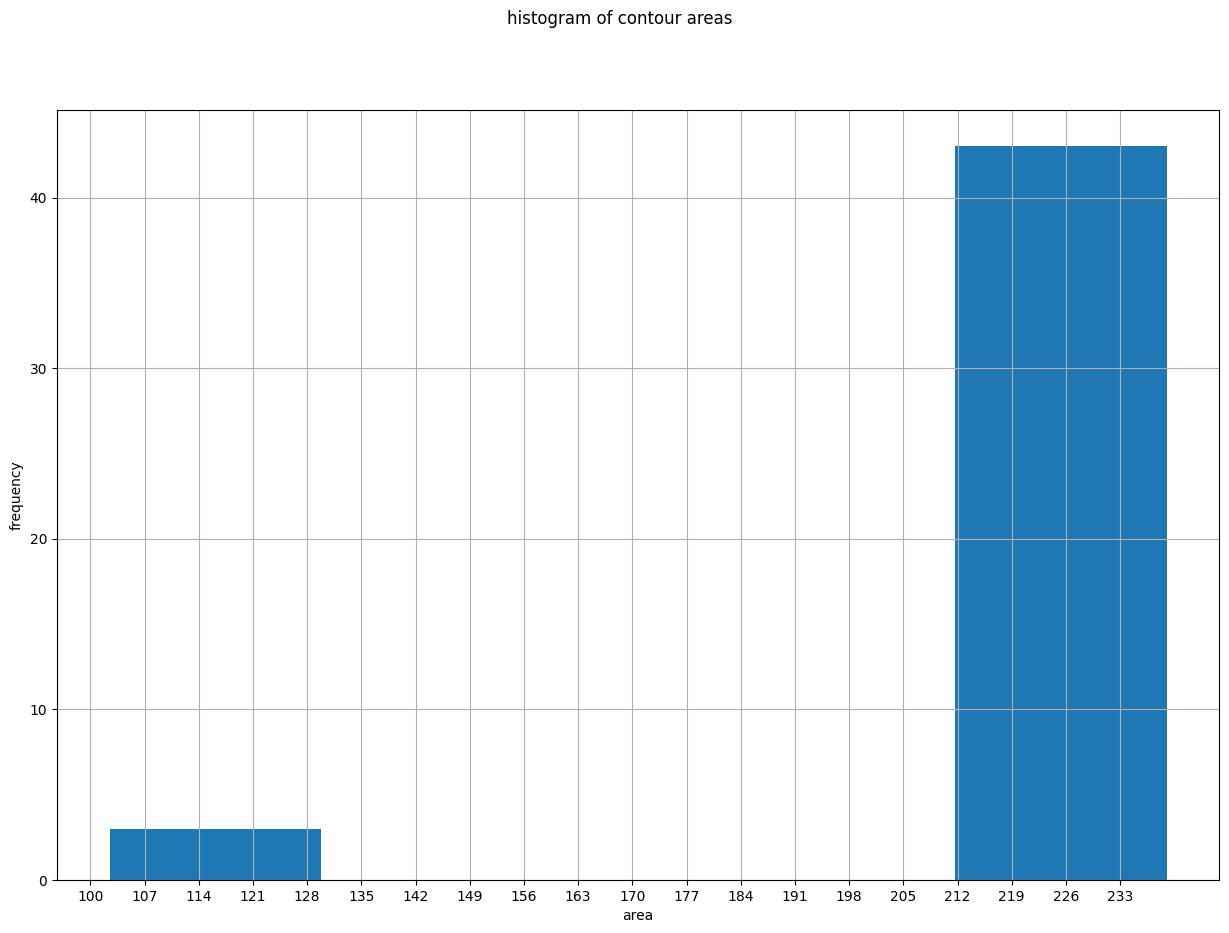

In [25]:
plt.figure(figsize=(15,10))
df["area"].hist(bins=5)
max_area = max(df["area"])
x_ticks_max = 500 if max_area > 500 else max_area
num_ticks = 20
ticks_steps = (x_ticks_max - 100) // num_ticks + 1
plt.suptitle("histogram of contour areas")
plt.xlabel("area")
plt.ylabel("frequency")
plt.xticks(range(100, int(x_ticks_max), int(ticks_steps)));

In [26]:
# lower_bound = 265
# upper_bound = 340

In [27]:
histogram, bins_ranges = generate_histogram(df["area"], n_bins=3)
histogram

{0: 3, 1: 0, 2: 42}

In [28]:
min(df["area"]), max(df["area"])

(102.5, 239.0)

In [29]:
lower_bound, upper_bound = get_max_bin_thresholds(histogram, bins_ranges)
lower_bound, upper_bound

(193.5, 239.0)

In [30]:
# filtered_contour = [filter_contour(ctr, 200,100) for ctr in ctrs]
def draw_contour(image, contours, lower_bound, upper_bound):
#     bubble_centers = []
#     bubble_bucket = []
#     parimeter_bucket = []
    out_image = image.copy()
    for ctr in contours:
        area = cv.contourArea(ctr)
        # len_condition = len(ctr) > 10 and len(ctr) < 50
        area_condition = area < upper_bound and area > lower_bound
        if area_condition:
            # computing center of contour
            M = cv.moments(ctr)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])

#                 bubble_centers.append((cX, cY))
#                 bubble_bucket.append(ctr)
#                 parimeter_bucket.append(cv.arcLength(ctr,True))
    #             print(cX, cY, cv.arcLength(ctr,True))
                cv.drawContours(out_image, [ctr], -1, (255,0,20), 1)
    return out_image

In [41]:
contoured_image = draw_contour(img, ctrs, lower_bound, upper_bound)
contoured_image.shape

(1000, 1000, 3)

In [42]:
df["area"].shape

(46,)

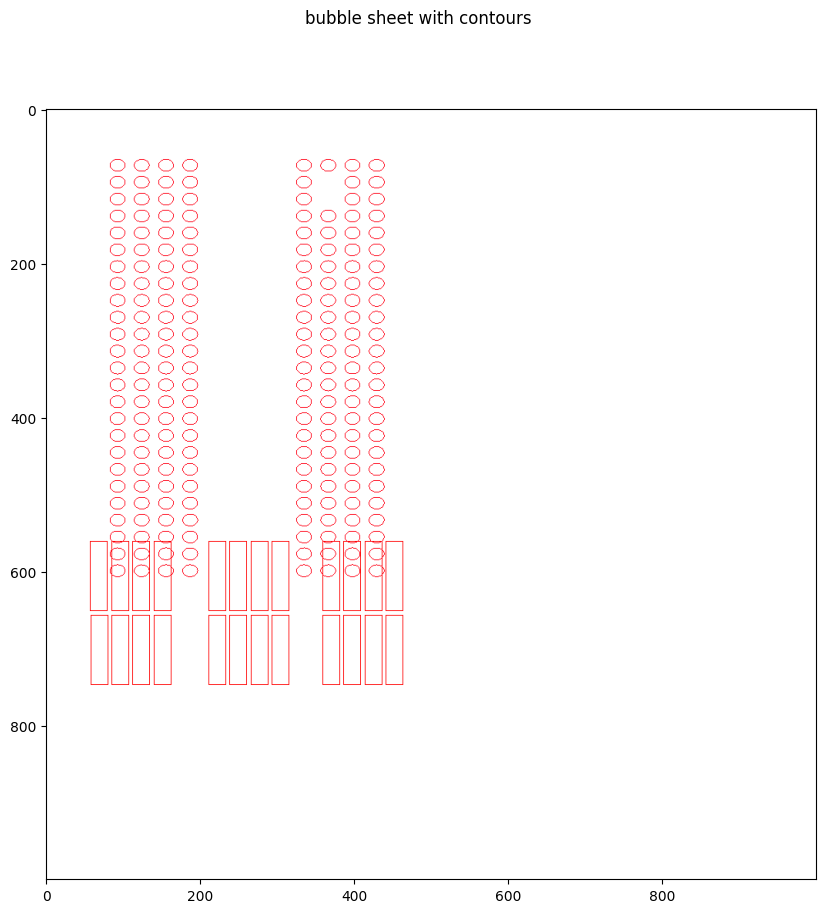

In [43]:
plt.figure(figsize=(10,10))
plt.imshow(contoured_image)
plt.suptitle("bubble sheet with contours")
plt.show();

Upon analyzing above result we can conclude:
- Unable to detect every bubble
- presence of incorrect detection

## Comparing the performance on multiple sheet

In [44]:
def draw_bubble_contour(img, original_img):
    # find all the contours in the image
    contours = cv.findContours(img, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    ctrs = imutils.grab_contours(contours)
    contours_features = bubble_contour_extractor(ctrs)  
    # transform contour features into dataframe
    df = pd.DataFrame(contours_features, columns=["area", "length", "parimeter"])
    # removing most probable noise
    df = df[(df["area"] < 500) & (df["area"] > 100) & (df["length"] > 5) & (df["length"] < 20)]
    
    histogram, bins_ranges = generate_histogram(df["area"], n_bins=3)

    lower_bound, upper_bound = get_max_bin_thresholds(histogram, bins_ranges)
    return draw_contour(original_img, ctrs, lower_bound, upper_bound)    

In [48]:
# multi_image_plot(contoured_images, cmap='brg')

##### upon analyzing the above result we can clearly see that we are able to detect bubble but for different sheets some bubble are getting missed. 
#### so the possible way to improve the accuracy is to improve the preprocessing stage and the other way is to tolerate this missed dataset in our evaluation stage.

# Phase II: contour segmentation
the detected contours that belongs to the same question will be grouped together

In [49]:
from statistics import median
from collections import defaultdict
import pandas as pd

In [73]:
def remove_noise(centers, contours, parimeters, tolerance = 5):
    median_parimeter = median(parimeters)
    new_centers = []
    new_contours = []
    for i in range(len(parimeters)):
        if (parimeters[i] < (median_parimeter + tolerance)) and (parimeters[i] > (median_parimeter - tolerance)):
            new_centers.append(centers[i])
            new_contours.append(contours[i])
    return new_centers, new_contours


def groupby_axis_y(bubble_centers, tolerance = 3):
    '''
    parameters:
        * bubble_centers : list of bubble centers 
        * tolerance: an integer that specifies the range of variation for equivalent values
    
    Description:
        This function transforms 1D list of contours into 2D where contours are grouped into rows
        (note that each row may contain corresponding row of more that one columns).
        Grouping is based on Y_coordinate of the bubble center. 
    
    returns:
        * 2D list -> grouped bubbles center
        * min_x, min_y -> minimum x and y coordinate (center of top-left bubble)
        * max_x, max_y -> maximum x and y coordinate
    '''
    groups = defaultdict(list)
    mapper = {}
    # initializing mapper
    x,y = bubble_centers[0]
    mapper[y] = (y-tolerance, y+tolerance)
    groups[y].append((x,y))
    min_x, max_x, min_y, max_y = x, x, y, y
    for x,y in bubble_centers[1:]:
        # grouping bubbles
        flag_found = False
        new_y = None
        
        for k,v in mapper.items():
            new_y = k
            if v[0] < y and v[1] > y:
                groups[k].append((x,new_y))
                flag_found = True
                break
        # if mapper doesnot have y already
        if not flag_found:
            mapper[y] = (y-tolerance, y+tolerance)
            groups[y].append((x,y))
            new_y = y
        # finding min and max x,y
        if x < min_x:
            min_x = x
        if new_y < min_y:
            min_y = new_y
        if x > max_x:
            max_x = x
        if new_y > max_y:
            max_y = new_y

    return list(groups.values()) , [(min_x, min_y), (max_x, max_y)]

# version 1***************
# def get_avg_x_spacing(row, ebpg):
#     ''' returns median of x_spacing of the given row if 
#     spacing  = []    
#     if len(row) < ebpg:
#       return None 
#     for i in range(1, len(row)):
#             spacing.append(row[i-1][0] - row[i][0])
#    
#     return statistics.median(spacing)

    
# version 2***************
def get_avg_x_spacing(groups_y, ebpg):
    '''
    parameters:
        * groups_y: list of row wised grouped bubbles center
        * ebpg (expected bubble per group): integer value that specifies the number of bubbles for a single question
    
    Description:
       Ebpg helps us to determine the number of bubbles in each column of a row.
       This function will check for the perfect rows where ever bubble is detected and there is no noise. 
       If no perfect rows is availabe then halt.
       Else, find the mode of median of spacing of two consecutive bubbles i.e X2 - X1.
       
       It will also calculate x_coordinate of a single perfect row by computing the columnwise mode of all the available perfect rows.
       This will basically determines the expected x_coordinate of each bubbles of each row.
       
    Returns:
        * minimum average x-spacing
        * perfect_row_x: mode of x_coordinates of the bubbles of perfect_rows; axis=0 -> columnwise  
        
    '''
    perfect_rows_x = [] # stores x coordinates of bubbles of perfect rows
    average_x_spacing = []
    
    columns_x = defaultdict(list) # stores the x coordinate of first bubble of each column group
    
    for row in groups_y:
        row = sorted(row)
        spacing  = []
        pointer = 0
        if len(row) % ebpg != 0: # if the row is perfect then when we divide it by the number of bubbles per question the remainder will be zero
            continue
    
        perfect_rows_x.append([x for x,y in row])
        
        for i in range(1, len(row)):
            if (i-1) % ebpg == 0 and (i-1) != 0:
                columns_x[pointer].append(row[i-1][0])
                pointer = (pointer + 1) % ebpg
            
            spacing.append(abs(row[i][0] - row[i-1][0]))
            
        # recording average x spacing of this row
        average_x_spacing.append(statistics.median(spacing))
#         average_x_spacing.append(statistics.mode(spacing))
    
    if len(average_x_spacing) > 0 and len(columns_x.values()) > 0:
        # find mode of perfect_rows column wise
        perfect_row_x = pd.DataFrame(perfect_rows_x).mode(axis=0)
        columns_x_mode = [statistics.mode(X) for X in columns_x.values()]
        return min(average_x_spacing), columns_x_mode, perfect_row_x.values.tolist()[0]
    else:
        return None

    

def groupby_axis_x(groups_y, min_x, max_x, tolerance=3, ebpg=4): #ebpg(expected bubble per group)=expected number of options/bubbles per question
    ''' 
    parameters:
        * groups_y: list of row wised grouped bubbles center
        * min_x, max_x = minimum and maximum x_coordinate 
        * tolerance =  an integer that specifies the range of variation for equivalent values 
        * ebpg (expected bubble per group): integer value that specifies the number of bubbles for a single question
        
    Description:
        It takes list of grouped bubbles (grouped into rows) and segment each rows into multiple columns. 
        For instance; [[1,2,3,4,5,6],[7,8,9,10,11,12]] is grouped into columns as 
                
                [[[1,2,3], [4,5,6]],
                 [[7,8,9], [10,11,12]]]
    Returns:
        * groups: 3D list of grouped bubbles
        * perfect_rows_x: x-coordinate of the bubbles center of a perfect rows 
    '''
    # setting 2D empty bucket
    groups = [[] for i in range(len(groups_y))]
    avg_distance, columns_x, perfect_row_x = get_avg_x_spacing(groups_y, ebpg)
    column_pointer = 0 # initially pointing to the zero th column
    if avg_distance is None: # there is not row that matches the specified ebpg, mean doesnot exist perfect rows (without missing bubble and noises)
        return []
    for i, row in enumerate(groups_y):
        row = sorted(row)
        previous_bubble_center_x = 0
        current_bubble_center_x = 0
        # checking if the first bubble of the row is detected or not
        if row[0][0] > (min_x - tolerance) and row[0][0] < (min_x + tolerance):
            groups[i].append([(row[0])])
            current_bubble_center_x = row[0][0]
        else:
            groups[i].append([(min_x, None)])
            current_bubble_center_x = min_x
        
        # now checkig for the rest of the bubble of the row
        bubble_index = 1
        while current_bubble_center_x < (max_x-tolerance):
                
            if len(row) > bubble_index and\
                   (abs(row[bubble_index][0] - current_bubble_center_x) < (avg_distance + tolerance) and\
                   abs(row[bubble_index][0] - current_bubble_center_x) > (avg_distance - tolerance)) :

                    # if one options set is covered then add list for new col group
                    groups[i][len(groups[i])-1].append(row[bubble_index])
                    previous_bubble_center_x = current_bubble_center_x
                    current_bubble_center_x = row[bubble_index][0]
                    bubble_index += 1
                    
                    
            # there is a missing bubble (unable to detect bubble)
            else:
                if len(groups[i][len(groups[i]) - 1]) % ebpg == 0: 

                    if len(row) > bubble_index and (row[bubble_index][0] < (columns_x[column_pointer] + tolerance)) and\
                    (row[bubble_index][0] > (columns_x[column_pointer] - tolerance)):
                        
                        groups[i].append([(columns_x[column_pointer], row[bubble_index][1])])
                        bubble_index += 1
                    
                    else:
                        groups[i].append([(columns_x[column_pointer], None)])
                        
                    previous_bubble_center_x = current_bubble_center_x
                    current_bubble_center_x = columns_x[column_pointer]
                    column_pointer = (column_pointer + 1) % len(columns_x)
                        
                else:
                    groups[i][len(groups[i]) - 1].append((None, None))
                    # last bubble of the group + average distance
                    previous_bubble_center_x = current_bubble_center_x
                    current_bubble_center_x = current_bubble_center_x + avg_distance
    return groups, perfect_row_x
    
    
def estimate_missing_bubbles(groups, perfect_row_x, ebpg=4): #consecutive bubble distance, row distance, coln distance
    '''
    Parameters: 
        * groups : 3D list of grouped bubbles obtained from groupby_axis_x function
        * perfect_row_x: x-coordinate of the bubbles of a perfect rows obtained from groupby_axis_x_function
    
    Description:
        it will replace the missing values in the groups by estimation the possible coordinate value for the missing bubbles
    
    Returns:
        * groups: 3D list of grouped bubbles where missing values are replaced with the estimated possible values
    '''
    for row_index, row in enumerate(groups):
        flat_row = [y for col in row for x,y in col]
        for col_index, col in enumerate(row):
            # flattern row
            for bubble_index, bubble in enumerate(col):
                # if x coordinate is missing
                if bubble[0] == None:
                    # convert non liner indexing to linear 
                    linear_index = col_index * ebpg + bubble_index
                    
                    new_x = perfect_row_x[linear_index]
                    old_y = groups[row_index][col_index][bubble_index][1]
                    groups[row_index][col_index][bubble_index] = (new_x, old_y)
                    
                # if y coordinate is missing
                if bubble[1] == None:
                    # find not none y or bubble[1]
                    unique_y = list(set(flat_row))

                    new_y = unique_y[0] if unique_y[0] else unique_y[len(unique_y) - 1]
                    old_x = groups[row_index][col_index][bubble_index][0]

                    groups[row_index][col_index][bubble_index] = (old_x, new_y)
    
    return groups

def get_x_y_spacing(groups, margin=5): # margin is the gap betwen two consecutive bubbles
    '''
    Parameters:
        * groups: groups obtained from estimate_missing_bubbles function
    
    Description:
        It will return the half of the distance between two consecutive bubbles (both X axis and Y axis)
    
    Returns:
        * h_spacing : half of the distance between two consecutive bubbles of a row 1
        * v_spacing : half of the distance between the first bubbles of two consecutive rows 
    '''
    print(groups)
    x_spacing = abs(groups[0][0][1][0] - groups[0][0][0][0]) 
    y_spacing = abs(groups[1][0][1][1] - groups[0][0][0][1])
    return int((x_spacing - margin)//2), int((y_spacing - margin)//2)


def plot_bubble_rec_bbox(groups, image, figsize=(10,10)):
    '''
    Parameters:
        * groups: groups obtained from estimate_missing_bubbles function
        
    Description:
        It will plot the rectangular bounding box around each bubbles
    
    Returns: 
        None but plots image with bounding rectangular box
    '''
    rect_w, rect_h = get_x_y_spacing(groups[:2])

    for rows in groups:
        for col in rows:
            for bubble in col:
                start_point = int(bubble[0] - rect_w), int(bubble[1] - rect_h)
                end_point = int(bubble[0] + rect_w), int(bubble[1] + rect_h)
                color = (255, 0, 0)
                thickness = 1
                image = cv.rectangle(image, start_point, end_point, color, thickness)

#     plt.figure(figsize=figsize)
    plt.axis(False)
    plt.imshow(image)
    plt.show()

In [74]:
groups = [[[(68, 606), (96, 606), (123, 606), (151, 606)],
          [(222, 606), (249, 606), (277, 606), (304, 606)],
          [(370, 606), (397, 606), (425, 606), (452, 606)]],
         [[(69, 702), (96, 702), (123, 702), (151, 702)],
          [(222, 702), (249, 702), (277, 702), (304, 702)],
          [(370, 702), (397, 702), (425, 702), (452, 702)]]]
# get_x_y_spacing(groups), (96- 68, 702 - 606)

[[[(68, 606), (96, 606), (123, 606), (151, 606)], [(222, 606), (249, 606), (277, 606), (304, 606)], [(370, 606), (397, 606), (425, 606), (452, 606)]], [[(69, 702), (96, 702), (123, 702), (151, 702)], [(222, 702), (249, 702), (277, 702), (304, 702)], [(370, 702), (397, 702), (425, 702), (452, 702)]]]


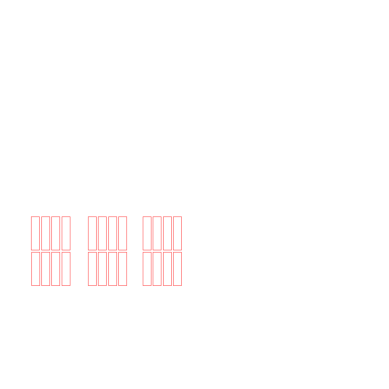

In [75]:
img = 255 * np.ones((1000,1000,3), dtype=np.uint16)

# resize image
plot_bubble_rec_bbox(groups, img , figsize=(5,5));

It seems our plot_bubble_bbox() function is working fine.

# Testing on image

In [76]:
def extract_bubbles_center(contours, lower_bound, upper_bound):
    '''
    returns the centerX and centerY of the bubble contours 
    from the given list of contours and the lower and upper
    threshold values of the corresponding bin of the contours
    '''
    bubbles_contour = []
    bubbles_center = []
    bubbles_parimeter = []
    for ctr in contours:
        area = cv.contourArea(ctr)
        area_condition = area < upper_bound and area > lower_bound
        if area_condition:
            # computing center of contour
            M = cv.moments(ctr)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])

                bubbles_contour.append(ctr)
                bubbles_parimeter.append(cv.arcLength(ctr,True))

                bubbles_center.append((cX, cY))
                
    return bubbles_contour, bubbles_center, bubbles_parimeter

def plot_contours(contours, image, plot=True):
    for cnt in contours:
        cv.drawContours(image, [cnt], -1, (0,255,20), 1)
    if plot:
        plt.axis(False)
        plt.imshow(image)
        plt.show()

In [77]:
def pipeline(image):
    binary_image = preprocessing(image.copy())
    contours = cv.findContours(binary_image, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    ctrs = imutils.grab_contours(contours)
    
    contours_features = bubble_contour_extractor(ctrs)
    df = pd.DataFrame(contours_features, columns=["area", "length", "parimeter"])
    df = df[(df["area"] < 500) & (df["area"] > 100) & (df["length"] > 5) & (df["length"] < 20)]
    histogram, bins_ranges = generate_histogram(df["area"], n_bins=3)
    
    lower_bound, upper_bound = get_max_bin_thresholds(histogram, bins_ranges)
    
    bubbles_contour, bubbles_center, bubbles_parimeter  = extract_bubbles_center(ctrs,
                                                                                 lower_bound,
                                                                                 upper_bound)
    
    bubbles_center, bubbles_contour = remove_noise(bubbles_center,
                                                   bubbles_contour,
                                                   bubbles_parimeter)
    
#     contoured_image = draw_contour(image, bubbles_contour, lower_bound, upper_bound) 
#     plt.figure(figsize=(10,10))
#     plt.imshow(contoured_image, cmap="gray")
#     plt.show()
#     return
    
    ebpg=4
    groups_y , min_max_bubble_center = groupby_axis_y(bubbles_center, tolerance=6)
    
    #-----------------------------------------------
    min_x = min_max_bubble_center[0][0]
    max_x = min_max_bubble_center[1][0]
    bubble_grouped, perfect_row_x_coords = groupby_axis_x(groups_y,
                                                          min_x,
                                                          max_x,
                                                          ebpg=ebpg,
                                                          tolerance=7)
    
    groups = estimate_missing_bubbles(bubble_grouped,
                                      perfect_row_x_coords,
                                      ebpg=ebpg)
    # we need to reverse groups 
    groups = list(reversed(groups))
    plot_contours(bubbles_contour, image, plot=False)
    plot_bubble_rec_bbox(groups, image, figsize=(10,15))
#     plt.imshow(binary_image[69-7:69+7, 101-7:101+7], cmap='gray')
    return groups


[[[(109, 108), (136.0, 108), (166, 108), (194, 108)], [(321, 108), (353, 108), (377.0, 108), (409, 108)]], [[(111, 128), (139, 128), (166, 128), (194, 128)], [(321, 128), (349.0, 128), (381, 128), (409, 128)]]]


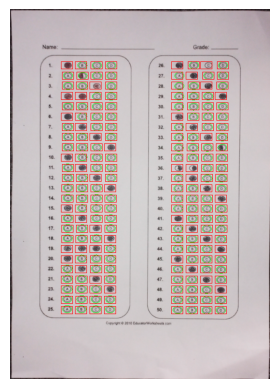

[[[(109, 108), (136.0, 108), (166, 108), (194, 108)],
  [(321, 108), (353, 108), (377.0, 108), (409, 108)]],
 [[(111, 128), (139, 128), (166, 128), (194, 128)],
  [(321, 128), (349.0, 128), (381, 128), (409, 128)]],
 [[(111, 147), (138, 147), (164.0, 147), (194, 147)],
  [(321, 147), (353, 147), (377.0, 147), (408, 147)]],
 [[(109, 167), (136.0, 167), (164.0, 167), (194, 167)],
  [(321, 167), (352, 167), (380, 167), (405.0, 167)]],
 [[(111, 187), (138, 187), (166, 187), (194, 187)],
  [(321, 187), (352, 187), (380, 187), (408, 187)]]]

In [82]:
img = cv.imread("../data/answer_sheet_filled_4.jpg")
img = imutils.resize(img, width=500)
groups = pipeline(img.copy())
# print(img.shape)
groups[:5]

##  phase III: Evaluation phase
Now we will evaluate the bubble sheet answers with the ground truth (which is made available through a csv file)

In [83]:
def compute_proportion_of_black(image): #image is an binary image
    '''
    Parameter:
        *image : takes an binarized image
        
    Description:
        It will calculate the percentage of black (0) pixels in that image.
    
    Returns:
        * proportion of black pixels
    '''
    # convert pixel value 255 into 1
    pixel_ones_count = (np.array(image)%254).sum()
    total_pixel = image.shape[0] * image.shape[1]

    # calculating the perportion of black in an image
    proportion_of_zeros = (total_pixel - pixel_ones_count)/total_pixel 
    return proportion_of_zeros

def crop_area(image):
    '''
    parameter: 
        *image: cropped image around the rectangular bounding box around a bubble
        
    Description:
        It will further cropped the image just to include the bubble, so that we will get more accurate result.
    
    Returns:
        *cropped image in a numpy array formate.
    '''
    new_rows = []
    # crop row
    for row in np.array(image)%254:
        sum_ = row.sum()
        if sum_ != len(row):
            new_rows.append(list(row))
    # crop columns
    df = pd.DataFrame(new_rows)
    for column in df.columns:
        if sum(df[column]) == len(df[column]):
            df.drop(column, axis=1, inplace=True)
    return np.array(df)

def detect_choice(question_bubble, image, rect_w, rect_h, black_percentage=0.65):
    '''
    Parameters:
        * question_bubble: list of center of bubbles of a particular question
        * image: binarized image of the bubble answer sheet
        * rect_w: width of a rectangular bounding box
        * rect_h: height of a rectangular bounding box
        * black_percentage: minimum percentage of black pixels for a chosen option
    
    Details:
        It will check each bubbles of a question and evaluate the proportion of black pixels in it, 
        based on that value it will determine which option is chosen and also accounts the errors. 
    
    Returns:
        * index of chosen option or -1 if no option is chosen or multiple options are chosen.
        
    '''
    choice = []
    for index, bubble in enumerate(question_bubble):

        bubble_area = image[round(bubble[1]- 12): round(bubble[1]+ 12),
                            round(bubble[0] - 12): round(bubble[0] + 12)]
        bubble_area = crop_area(bubble_area)
#         plt.imshow(bubble_area, cmap='gray')
#         plt.show()
        proportion_of_zeros = compute_proportion_of_black(bubble_area)
        if proportion_of_zeros >= black_percentage:
            choice.append(index+1)
    if len(choice) == 1:
        return choice[0]
    else:
        return -1

In [84]:
# d = pd.DataFrame({"A":[1,2,3,4], "B": [5,6,7,8]})
# # d.drop(["A"], inplace=True, axis=1)
# d.tolist()
# def show():
#     (np.array([[0, 0, 255], [255, 0, 255]])/255).astype('int')
# %timeit -r 4 -n 1000 show()

In [85]:
# def show():
#     np.array([[0, 0, 255], [255, 0, 255]])%254
    
# %timeit -r 4 -n 1000 show()

In [86]:
rect_w, rect_h = get_x_y_spacing(groups[:2])

# let's take minimum(width, height) as width and height
# rect_w = rect_h = min(rect_w, rect_h)

binary_image = preprocessing(img.copy())

first_choice = detect_choice(groups[0][0], binary_image, rect_w, rect_h)
second_choice = detect_choice(groups[1][0], binary_image, rect_w, rect_h)
third_choice = detect_choice(groups[2][0], binary_image, rect_w, rect_h)
fourth_choice = detect_choice(groups[4][0], binary_image, rect_w, rect_h)


print(f"first choice:{first_choice} \nsecond choice: {second_choice} \nthird choice : {third_choice} \nfourth choice: {fourth_choice}")

[[[(109, 108), (136.0, 108), (166, 108), (194, 108)], [(321, 108), (353, 108), (377.0, 108), (409, 108)]], [[(111, 128), (139, 128), (166, 128), (194, 128)], [(321, 128), (349.0, 128), (381, 128), (409, 128)]]]
first choice:1 
second choice: 2 
third choice : 3 
fourth choice: -1


In [88]:
import math

ebpg = 4
total_questions = 50
len_column = len(groups)
num_column = math.ceil(total_questions/len_column)
answers = []
for column in range(0, num_column):
    for question_no in range(0, len(groups)):
        answers.append(detect_choice(groups[question_no][column], binary_image, rect_w, rect_h))
        
print("Answers: ", answers, 
      "\nlength: ", len(answers))

Answers:  [1, 2, 3, -1, -1, 1, 2, 3, 4, 1, 2, 3, 4, -1, 1, -1, 3, 4, -1, 1, 2, 3, 4, -1, -1, 1, 2, 3, 4, -1, 1, 2, 3, 4, -1, 1, 2, 3, 4, -1, 1, 2, 3, 4, 1, -1, -1, 4, -1, -1] 
length:  50


In [89]:
# actual user choices 
# answer_sheet_filled_4
actual_user_choices = [
                       1, 2, 3, -1, -1,
                       1, 2, 3, 4, 1,
                       2, 3, 4, -1, 1,
                       2, 3, 4, -1, 1,
                       2, 3, 4, -1, -1,
                       1, 2, 3, 4, -1,
                       1, 2, 3, 4, -1,
                       -1, 2, 3, 4, -1,
                       1, 2, 3, 4, 1,
                       2, 3, 4, -1, -1
                      ]

# answer sheet filled 7

# actual_user_choices = [
#     1, 2, 3, 4, -1, -1, 1, 2, 3, 4,
#     -1, -1, 1, 2, 1, 2, 3, 4,-1, -1,
#     1, 2, 3, 4, -1, 1, 2, 3, 4, -1,
#     -1, 1, 2, 3, 4, -1, -1 , -1, 1, 2,
#     3, 4, -1, -1, 1, 2, 3, 4, -1, -1,
#     1, 2, 3, 4, 1, 2, 3, 4, 1, 2,
#     3, 4, 1, 2, 3, 4, 1, 2, 3, 4,
#     1, 2, 3, 4, -1,
# ]
len(actual_user_choices)

50

In [90]:
# checking accuracy of our model
total_questions = len(actual_user_choices)
matched_count = 0
for detected, actual in zip(answers, actual_user_choices):
    if detected == actual:
         matched_count += 1
            
accuracy = matched_count / total_questions * 100
print(f" accuracy : {accuracy}")
print(f" total questions: {total_questions}")
print(f" matched count: {matched_count}")
        

 accuracy : 92.0
 total questions: 50
 matched count: 46


# Loading and writing obtained marks

In [97]:
# loading csv
correct_answers = pd.read_csv("correct_answers.csv")
correct_answers.head()

,Qn,correct answers
0,1,1
1,2,2
2,3,2
3,4,3
4,5,3


In [98]:
total_questions = correct_answers.shape[0]
matched_count = 0
for detected, correct in zip(answers, correct_answers["correct answers"]):
    if detected == correct:
        matched_count += 1
        
print(f" total questions: {total_questions}")
print(f" obtained marks: {matched_count}")

 total questions: 50
 obtained marks: 12


In [99]:
groupby_axis_x([[(452, 606), (425, 606), (397, 606), (370, 606), (304, 606),
                       (277, 606), (249, 606), (222, 606), (151, 606), (123, 606), 
                       (96, 606),(68, 606)], [(69, 702), (452, 702)]] , 68, 452 , ebpg=4)

([[[(68, 606), (96, 606), (123, 606), (151, 606)],
   [(222, 606), (249, 606), (277, 606), (304, 606)],
   [(370, 606), (397, 606), (425, 606), (452, 606)]],
  [[(69, 702), (None, None), (None, None), (None, None)],
   [(222, None), (None, None), (None, None), (None, None)],
   [(370, None), (None, None), (None, None), (452, 702)]]],
 [68, 96, 123, 151, 222, 249, 277, 304, 370, 397, 425, 452])

## utils functions testing

In [103]:
def perform_testing(func, testcases):
    for test_index, test_case in testcases.items():
        output = func(**test_case["input"])
        expected_output = test_case["output"]
        status = output == expected_output
        
        if status: # true
            status_text = "\x1b[1;03;34;15m True \x1b[0m"
        else:
            status_text = "\x1b[1;03;31;15m False \x1b[0m"
            
        print("\x1b[1;03;41;06m  test_case:  \x1b[0m {} \n \
                \x1b[1;23;11;06m expected output: \x1b[0m {} \n \
                \x1b[1;23;11;06m real output: \x1b[0m {} \n \
                \x1b[1;23;11;06m passed: \x1b[0m {} \n"\
              .format(test_index, test_case["output"], output, status_text))
        print("-----------------------------")

In [104]:
testcases_groupby_axis_y = {
        "test_1": {
            "input" : {
                "bubble_centers": [(1, 2), (3, 2), (4, 3), (5, 7), (6, 7), (7, 7)]
                 },
            "output": ([[(1, 2), (3, 2), (4, 2)], [(5, 7), (6, 7), (7, 7)]] , [(1, 2), (7, 7)] )
        },
        "test_2": {
            "input":  {
                "bubble_centers": [[452, 606], [425, 606 ], [397, 605], [370, 605], [304, 605],
                       [277, 606], [249, 605], [222, 605], [151, 606], [123, 606], 
                       [96, 606],[68, 606], [69, 702], [452,702]]
                      },
            "output": ([[(452, 606), (425, 606), (397, 606), (370, 606), (304, 606),
                       (277, 606), (249, 606), (222, 606), (151, 606), (123, 606), 
                       (96, 606),(68, 606)], [(69, 702), (452, 702)]] , [(68, 606), (452, 702)])
        },
        "test_3": {
            "input": {
                "bubble_centers": [(1,1), (10,1), (20,2), (40, 1),
                                   (51, 1), (62,2), (1,10), (11, 10),
                                   (19, 10), (40, 10), (50, 10), (61, 9)] 
                    },
            "output": ([[(1,1), (10,1), (20,1), (40, 1), (51, 1), (62,1)],
                        [(1,10), (11, 10), (19, 10), (40, 10), (50, 10), (61, 10)]], [(1, 1), (62, 10)])
        }
    
}

In [105]:
# testing groupby_axis_y
perform_testing(groupby_axis_y, testcases_groupby_axis_y)

ok
  test_case:   test_1 
                  expected output:  ([[(1, 2), (3, 2), (4, 2)], [(5, 7), (6, 7), (7, 7)]], [(1, 2), (7, 7)]) 
                  real output:  ([[(1, 2), (3, 2), (4, 2)], [(5, 7), (6, 7), (7, 7)]], [(1, 2), (7, 7)]) 
                  passed:   True  

-----------------------------
ok
  test_case:   test_2 
                  expected output:  ([[(452, 606), (425, 606), (397, 606), (370, 606), (304, 606), (277, 606), (249, 606), (222, 606), (151, 606), (123, 606), (96, 606), (68, 606)], [(69, 702), (452, 702)]], [(68, 606), (452, 702)]) 
                  real output:  ([[(452, 606), (425, 606), (397, 606), (370, 606), (304, 606), (277, 606), (249, 606), (222, 606), (151, 606), (123, 606), (96, 606), (68, 606)], [(69, 702), (452, 702)]], [(68, 606), (452, 702)]) 
                  passed:   True  

-----------------------------
ok
  test_case:   test_3 
                  expected output:  ([[(1, 1), (10, 1), (20, 1), (40, 1), (51, 1), (62, 1)], [(1, 10), (11, 10

In [106]:
# test cases for get_avg_x_spacing
testcases_avg_x_spacing = {
    "test_1": { # when there is no missing bubble contour
        "input": {
            "groups_y": [[(1,1), (10,1), (20,1), (40, 1), (51, 1), (62,1)],
                                  [(1,10), (11, 10), (19, 10), (40, 10), (50, 10), (61, 10)]],
            "ebpg": 3
        },
        "output": 10
    },
    "test_2": { # when we have some missing bubbles
        "input": {
            "groups_y": [[(1,1), (10,1), (20,1), (40, 1), (51, 1)], # missing one bubble
                         [(1,10), (19, 10),(20,10), (40, 10), (50, 10), (61, 10)]],
            "ebpg": 3
        },
        "output": 11
    }
}

perform_testing(get_avg_x_spacing, testcases_avg_x_spacing)

  test_case:   test_1 
                  expected output:  10 
                  real output:  (10, [40], [1.0, 10.0, 19.0, 40.0, 50.0, 61.0]) 
                  passed:   False  

-----------------------------
  test_case:   test_2 
                  expected output:  11 
                  real output:  (11, [40], [1, 19, 20, 40, 50, 61]) 
                  passed:   False  

-----------------------------


In [107]:
# test cases for groupby_axis_x function
testcases_groupby_axis_x = {
        "test_1": {
            "input": { # normal case when it's a perfect detection
                    "groups_y": [[(1,1), (10,1), (20,1), (40, 1), (51, 1), (62,1)],
                                  [(1,10), (11, 10), (19, 10), (40, 10), (50, 10), (61, 10)]],
                    "min_x" : 1, 
                    "max_x": 62,
                    "ebpg": 3
                    },
            "output": [
                        [[(1,1), (10,1), (20,1)], [(40, 1), (51, 1), (62,1)]],
                        [[(1,10), (11, 10), (19, 10)], [(40, 10), (50, 10), (61, 10)]]
                      ]
        },
        "test_2": {
                "input": { # normal case when there is a missing bubble in the first row
                        "groups_y": [[(1,1), (10,1), (20,1), (51, 1), (62,1)],
                                      [(1,10), (11, 10), (19, 10), (40, 10), (50, 10), (61, 10)]],
                        "min_x" : 1, 
                        "max_x": 62,
                        "ebpg": 3
                        },
                "output": [
                            [[(1,1), (10,1), (20,1)], [(40, None), (51, 1), (62,1)]],
                            [[(1,10), (11, 10), (19, 10)], [(40, 10), (50, 10), (61, 10)]]
                          ]
            },
      "test_3":{
        "input": {
            "groups_y": [[(452, 606), (425, 606), (397, 606), (370, 606), (304, 606),
                       (277, 606), (249, 606), (222, 606), (151, 606), (123, 606), 
                       (96, 606),(68, 606)], [(69, 702), (452, 702)]],
            "min_x": 68,
            "max_x": 452,
            "ebpg": 4
        },
        "output": [[[(68, 606), (96, 606), (123, 606), (151, 606)],
                    [(222, 606), (249, 606), (277, 606), (304, 606)],
                    [(370, 606), (397, 606), (425, 606), (452, 606)]],
                  [[(69, 702), (None, None), (None, None), (None, None)],
                    [(222, None), (None, None), (None, None), (None, None)],
                    [(370, None), (None, None), (None, None), (452, 702)]]]
    }
    
}

In [108]:
perform_testing(groupby_axis_x, testcases_groupby_axis_x)

  test_case:   test_1 
                  expected output:  [[[(1, 1), (10, 1), (20, 1)], [(40, 1), (51, 1), (62, 1)]], [[(1, 10), (11, 10), (19, 10)], [(40, 10), (50, 10), (61, 10)]]] 
                  real output:  ([[[(1, 1), (10, 1), (20, 1)], [(40, 1), (51, 1), (62, 1)]], [[(1, 10), (11, 10), (19, 10)], [(40, 10), (50, 10), (61, 10)]]], [1.0, 10.0, 19.0, 40.0, 50.0, 61.0]) 
                  passed:   False  

-----------------------------
  test_case:   test_2 
                  expected output:  [[[(1, 1), (10, 1), (20, 1)], [(40, None), (51, 1), (62, 1)]], [[(1, 10), (11, 10), (19, 10)], [(40, 10), (50, 10), (61, 10)]]] 
                  real output:  ([[[(1, 1), (10, 1), (20, 1)], [(40, None), (51, 1), (62, 1)]], [[(1, 10), (11, 10), (19, 10)], [(40, 10), (50, 10), (61, 10)]]], [1, 11, 19, 40, 50, 61]) 
                  passed:   False  

-----------------------------
  test_case:   test_3 
                  expected output:  [[[(68, 606), (96, 606), (123, 606), (151, 606)],

In [109]:
# testing estimate missing bubbles
testcases_estimate_missing_bubbles = {
        "test_1": {
            "input": { # normal case when it's a perfect detection
                    "groups": [[[(68, 606), (96, 606), (123, 606), (151, 606)],
                               [(222, 606), (249, 606), (277, 606), (304, 606)],
                               [(370, 606), (397, 606), (425, 606), (452, 606)]],
                              [[(69, 702), (None, None), (None, None), (None, None)],
                               [(222, None), (None, None), (None, None), (None, None)],
                               [(370, None), (None, None), (None, None), (452, 702)]]],
                    "perfect_row_x": [68, 96, 123, 151, 222, 249, 277, 304, 370, 397, 425, 452], 
                    "ebpg": 4
                    },
            "output": [[[(68, 606), (96, 606), (123, 606), (151, 606)],
                        [(222, 606), (249, 606), (277, 606), (304, 606)],
                        [(370, 606), (397, 606), (425, 606), (452, 606)]],
                       [[(69, 702), (96, 702), (123, 702), (151, 702)],
                        [(222, 702), (249, 702), (277, 702), (304, 702)],
                        [(370, 702), (397, 702), (425, 702), (452, 702)]]]
        }
    }

In [110]:
perform_testing(estimate_missing_bubbles, testcases_estimate_missing_bubbles)

  test_case:   test_1 
                  expected output:  [[[(68, 606), (96, 606), (123, 606), (151, 606)], [(222, 606), (249, 606), (277, 606), (304, 606)], [(370, 606), (397, 606), (425, 606), (452, 606)]], [[(69, 702), (96, 702), (123, 702), (151, 702)], [(222, 702), (249, 702), (277, 702), (304, 702)], [(370, 702), (397, 702), (425, 702), (452, 702)]]] 
                  real output:  [[[(68, 606), (96, 606), (123, 606), (151, 606)], [(222, 606), (249, 606), (277, 606), (304, 606)], [(370, 606), (397, 606), (425, 606), (452, 606)]], [[(69, 702), (96, 702), (123, 702), (151, 702)], [(222, 702), (249, 702), (277, 702), (304, 702)], [(370, 702), (397, 702), (425, 702), (452, 702)]]] 
                  passed:   True  

-----------------------------


# Approach II:  clustering 

In [112]:
img = cv.imread("../data/answer_sheet1.jpg")
# resize image
img = imutils.resize(img, width=500)

In [113]:
def contour_feature_extractor(contours):
    contours_features = []
    for index, ctr in enumerate(contours):
        if len(ctr) > 3:
            M = cv.moments(ctr)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
                contours_features.append([index, cv.contourArea(ctr), len(ctr), cX, cY, cv.arcLength(ctr,False)]) 
    contours_features = np.array(contours_features)
    return contours_features

In [114]:
contour_feature = pd.DataFrame(contour_feature_extractor(ctrs), columns=["index", "area", "length", "x", "y", "parameter"])
contour_feature.shape

(652, 6)

In [115]:
input_contour_feature = contour_feature.copy()
# input_contour_feature.drop(["index", "x", "y", "length"], axis=1, inplace=True)
input_contour_feature.shape

(652, 6)

In [116]:
input_contour_feature.corr()

,index,area,length,x,y,parameter
index,1.000000,0.129699,0.078049,-0.004458,-0.988289,0.155855
area,0.129699,1.000000,0.276518,-0.002953,-0.000998,0.902757
length,0.078049,0.276518,1.000000,-0.016885,0.013899,0.547185
x,-0.004458,-0.002953,-0.016885,1.000000,-0.007830,-0.010721
y,-0.988289,-0.000998,0.013899,-0.007830,1.000000,-0.008627
parameter,0.155855,0.902757,0.547185,-0.010721,-0.008627,1.000000


In [117]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

ModuleNotFoundError: No module named 'sklearn'

In [118]:
def build_pipeline(model, nominal_features=[], ordinal_features=[], quantitative_features=[]):
    # pipe for categorical var
    nominal_pipe = make_pipeline(
                OneHotEncoder()
    )
    # ordinal pipe
    ordinal_pipe = make_pipeline(
            OrdinalEncoder()
    )
    # pipe for quantative pipe
    quantitative_pipe = make_pipeline(
            StandardScaler()
    )
    # block A
    block_A = [
        ('quantative', quantitative_pipe, quantitative_features),
        ("ordinal", ordinal_pipe, ordinal_features),
        ('nominal', nominal_pipe, nominal_features)
    ]
    
    if model:
        return make_pipeline(
                    ColumnTransformer(block_A),
                    model
        )
    else:
        return make_pipeline(
                ColumnTransformer(block_A)
        )

In [ ]:
quantitative_cols  = list(input_contour_feature.columns)
quantitative_cols

In [ ]:
encoder_pipe = build_pipeline(None, quantitative_features=quantitative_cols)

In [ ]:
input_X = encoder_pipe.fit_transform(input_contour_feature)
input_X.shape

In [ ]:
n_clusters = 4
kmean_cluster_model = KMeans(n_clusters=n_clusters, random_state=0)
agg_clustering_model = AgglomerativeClustering(n_clusters=n_clusters)


model = kmean_cluster_model
# model = agg_clustering_model

In [ ]:
result = model.fit(input_X)

In [ ]:
contour_feature["label"] = result.labels_

In [ ]:
contour_feature["label"].unique()

In [ ]:
cluster_bucket = []

In [ ]:
for i in range(0, n_clusters):
    cluster_bucket.append(contour_feature[contour_feature["label"] == i])
    print(f"cluster {i} shape: ",len(cluster_bucket[i]))

In [ ]:
#cluster_2 checking
cluster_indices = cluster_bucket[0]["index"].astype("int")
cluster_indices[:10]

In [ ]:
def get_contour_with_index(indices, contours):
    contours_ = [contours[i] for i in indices]
    return contours_
        

In [ ]:
contours_cluster = get_contour_with_index(cluster_indices, ctrs)
len(contours_cluster)

In [ ]:
output_image = img.copy()
for ctr in contours_cluster:
    cv.drawContours(output_image, [ctr], -1, (0,255,20), 1)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(output_image);